# Первое задание.
## Работу выполнил: Шурыгин Антон, Б01 - 909.
____________________

### Генерация индивидуального варианта.


In [ ]:
import numpy as np
from zlib import crc32

types = ['regression', 'classification']
datasets = {'regression': [{'name': 'Servo Data Set',
                            'url': 'https://archive.ics.uci.edu/ml/datasets/Servo'}, 
                           {'name': 'Forest Fires Data Set',
                            'url': 'https://archive.ics.uci.edu/ml/datasets/Forest+Fires'},
                           {'name': 'Boston Housing Data Set',
                            'url': 'https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_boston.html#sklearn.datasets.load_boston'}, 
                           {'name': 'Diabetes Data Set',
                            'url': 'https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_diabetes.html#sklearn.datasets.load_diabetes'}],
            'classification': [{'name': 'Spambase Data Set',
                                'url': 'https://archive.ics.uci.edu/ml/datasets/Spambase'}, 
                               {'name': 'Wine Data Set',
                                'url': 'https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_wine.html#sklearn.datasets.load_wine'}, 
                               {'name': 'Breast Cancer Data Set',
                                'url': 'https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_breast_cancer.html#sklearn.datasets.load_breast_cancer'}, 
                               {'name': 'MNIST',
                                'url': 'http://yann.lecun.com/exdb/mnist/'}]}
methods = {'regression': ['Линейная регрессия', 
                          'Перцептрон', 
                          'Надарая-Ватсона',
                          'SVR'],
           'classification': ['Логистическая регрессия', 
                              'Перцептрон', 
                              'k-ближайших соседей',
                              'Метод потенциальных функций',
                              'Метод Парзеновского окна', 
                              'SVM']}
task = dict()
task['mail'] = input(prompt='Enter your mail: ')
task['id'] = crc32(task['mail'].encode('utf-8'))
np.random.seed(task['id'])
task['type'] = np.random.choice(types)
task['dataset'] = np.random.choice(datasets[task['type']])
task['method'] = np.random.choice(
    methods[task['type']], size=3, replace=False).tolist()


task

### Подключаем небоходимые модули

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# pretty data table dump
from google.colab import data_table
data_table.enable_dataframe_formatter()

# pretty plot view
from google.colab import widgets

from sklearn.metrics import mean_squared_error, r2_score

### Определим сущность ***DataWrapper*** - класс владеющий и управляющий загруженным датасетом.

Краткая документация всех методов приведена над соответствующим методом.

In [ ]:
class DataWrapper:
  def __init__(self, path : str = str(), feature_vars : list = list(), target_vars : list = list()):
    #
    self.feature_vars = feature_vars
    self.target_vars = target_vars
    self.all_vars = feature_vars + target_vars
    #
    self.dataset = pd.read_csv(path, names=self.all_vars, header=0)
    print(f'Размер выборки составляет l={len(self.dataset)} объектов.')
    #
    self.feature_test, self.feature_train = None, None 
    self.target_test, self.target_train = None, None
    #
  
  # NOTE: simple plot builder
  def get_plot(self, x, y, title : str = str(), xlab : str = str(), ylab : str = str()):
    plt.figure(figsize=(16,10))
    plt.scatter(x, y, c = 'r')

    plt.xlabel(xlab)
    plt.ylabel(ylab)
    plt.title(title)
    #
  
  # NOTE: pretty seaborn hist dump
  def get_pretty_hist(self, name : str):
    plt.figure(figsize=(16,10))
    sns.countplot(self.dataset[name])
    plt.title(name)
      #
  
  # NOTE: simple hist dump
  def get_hist(self, data, title):
    plt.figure(figsize=(16,10))
    plt.hist(data)
    plt.title(title)
      #
  
  # NOTE: function to dump histogram for every var from vars list
  # in special colab tabs 
  def get_hist_in_tabs(self, dataset, vars):
    #
    tab_bar = widgets.TabBar(vars)
    for var_it in vars:
      with tab_bar.output_to(var_it):
        self.get_hist(dataset[var_it], var_it)
          #
  
  # NOTE: function to build plot for every var from vars list
  # in special colab tabs
  def get_plot_in_tabs(self, x_data, y_data, vars : list = list()):
    tab_bar = widgets.TabBar(vars)

    for var_it, column in zip(vars, x_data.columns):
        with tab_bar.output_to(var_it):
          self.get_plot(x=x_data[column], y=y_data, title=f"Plot {var_it}, burned area", xlab=var_it, ylab="area")
          #
  
  # NOTE: correlation heatmap builder & dump
  def get_corr(self, data : pd.DataFrame):
    # train_joined = features_train.join(target_train)
    corr_mat = data.corr()

    plt.figure(figsize=(30, 15))
    sns.heatmap(corr_mat, cmap='coolwarm', annot=True)
    plt.show()
    #
  
  # NOTE: custom dataset splitter
  def split_dataset(self, dataset : pd.DataFrame, target_var, testsize : float, random_st : int):
    feautres = dataset.drop(target_var, axis = 1)
    target = dataset[target_var].values.reshape(-1, 1)

    self.features_train, self.features_test,\
                         self.target_train, self.target_test = train_test_split(feautres, target,\
                                                                                test_size = testsize, random_state=random_st)
    #
  
  # NOTE: custom feature data scaller
  def scale_features(self):
    sc_feature = StandardScaler()
    #
    self.features_test = sc_feature.fit_transform(self.features_test)
    self.features_train = sc_feature.transform(self.features_train)
    #
  #
  def scale_target(self):
    sc_target = StandardScaler()
    #
    self.target_test = sc_target.fit_transform(self.target_test)
    self.target_train = sc_target.transform(self.target_train)

    #
  #
  # NOTE: cast feature & target data to pandas DataFrame
  def data2dataframe(self):
    self.features_test = pd.DataFrame(self.features_test, columns = self.feature_vars)
    self.features_train = pd.DataFrame(self.features_train, columns = self.feature_vars)
    self.target_test = pd.DataFrame(self.target_test, columns = self.target_vars)
    self.target_train = pd.DataFrame(self.target_train, columns = self.target_vars)
    #
  
  # NOTE: cast feature & target data to numpy array
  def data2numpyarr(self):
    self.features_train = self.features_train.to_numpy()
    self.features_test = self.features_test.to_numpy()  
    self.target_train = self.target_train.to_numpy()
    self.target_test = self.target_test.to_numpy()
    #
    # NOTE: target vector reshaping from (n, 1) to (n,)
    self.target_train = self.target_train.reshape((self.target_train.shape[0], ))
    self.target_test = self.target_test.reshape((self.target_test.shape[0], ))

  def upd_features(self, new_features):
    self.features_train = self.features_train.loc[:, new_features]
    self.features_test = self.features_test.loc[: , new_features]
    #
  #

  # NOTE: function to run any model
  def run_model(self, model, dump = False):
    pred_train = model.predict(self.features_train)
    #
    r2_train = r2_score(self.target_train, pred_train)
    rmse_train = mean_squared_error(self.target_train, pred_train, squared = False)
    #
    if dump:
      print(f"For the train set the r2 is: {r2_train:.5f}\nThe RMSE is: {rmse_train:.5f}")

    pred_test = model.predict(self.features_test)
    r2_test = r2_score(self.target_test, pred_test)
    rmse_test = mean_squared_error(self.target_test, pred_test, squared = False)
    #
    if dump:
      print(f"For the test set the r2 is: {r2_test:.5f}\nThe RMSE is: {rmse_test:.5f}")

    return pred_test, r2_test
    #
  #
  def plot_compare(self, target_test_predict):
    plt.figure(figsize=[40,15])
    plt.plot(self.target_test, color = "red", label = 'True value')
    plt.plot(target_test_predict, label = 'Predicted value')
    plt.title('Evaluation result')
    #
    plt.grid()
    plt.legend(prop={'size': 20})

    plt.show()
    #
  #
  def evaluation(self, target_test_predict):
    #
    fig, ax = plt.subplots(figsize=(10,6))
    ax.scatter(self.target_test, target_test_predict)
    ax.plot(ax.get_xlim(), ax.get_ylim(), color ='red')
    #
    plt.xlabel('True value')
    plt.ylabel('Predicted values')
    plt.title('Evaluation result')
    plt.show()
    #
  #


# NOTE: function to check variation inflation factor
def check_vif(features_train):
  vif = pd.Series([variance_inflation_factor(features_train.values, i) 
                  for i in range(features_train.shape[1])], 
                index = features_train.columns)
  print(vif)

  # NOTE: padnas DataFrame concat
def join_data(lhs : pd.DataFrame, rhs : pd.DataFrame):
  return lhs.join(rhs)

### Загрузим и выведем полученные данные.

In [ ]:
data_https = "https://archive.ics.uci.edu/ml/machine-learning-databases/forest-fires/forestfires.csv"
feature_var = ['X', 'Y', 'month', 'day', 'FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH', 'wind', 'rain']
target_var = ['area']

wrapp = DataWrapper(data_https, feature_var, target_var)
wrapp.dataset

Размер выборки составляет l=517 объектов.


,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
0,7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.00
1,7,4,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.00
2,7,4,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.00
3,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.00
4,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
512,4,3,aug,sun,81.6,56.7,665.6,1.9,27.8,32,2.7,0.0,6.44
513,2,4,aug,sun,81.6,56.7,665.6,1.9,21.9,71,5.8,0.0,54.29
514,7,4,aug,sun,81.6,56.7,665.6,1.9,21.2,70,6.7,0.0,11.16
515,1,4,aug,sat,94.4,146.0,614.7,11.3,25.6,42,4.0,0.0,0.00


## 1. Анализ датасета.



### В данной задачи исходное множество описывается 12 входными переменными:

1. X - пространственная координата по оси x на карте парка Монтесиньо

2. Y - пространственная координата по оси Y на карте парка Монтесиньо

3. месяц - месяц года: от "янв" до "декабрь"

4. день - день недели: от "пн" до "вс"

5. FFMC — индекс FFMC из системы FWI

6. DMC - индекс DMC по системе FWI

7. DC - индекс DC по системе FWI

8. ISI - индекс ISI из системы FWI

9. temp - температура в градусах Цельсия

10. RH - относительная влажность в %

11. ветер - скорость ветра в км/ч

12. дождь - дождь снаружи в мм/м2

### И одной выходной переменной:

1. area - сгоревшая площадь леса (в га)

### Анализируем полученные данные:

- Расссмотим гистограммы полученных данных: 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

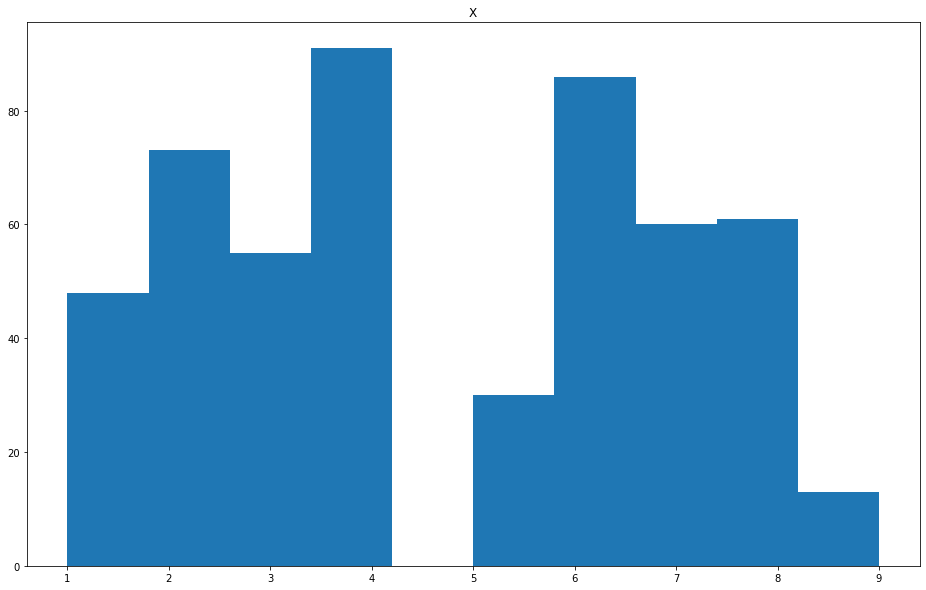

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

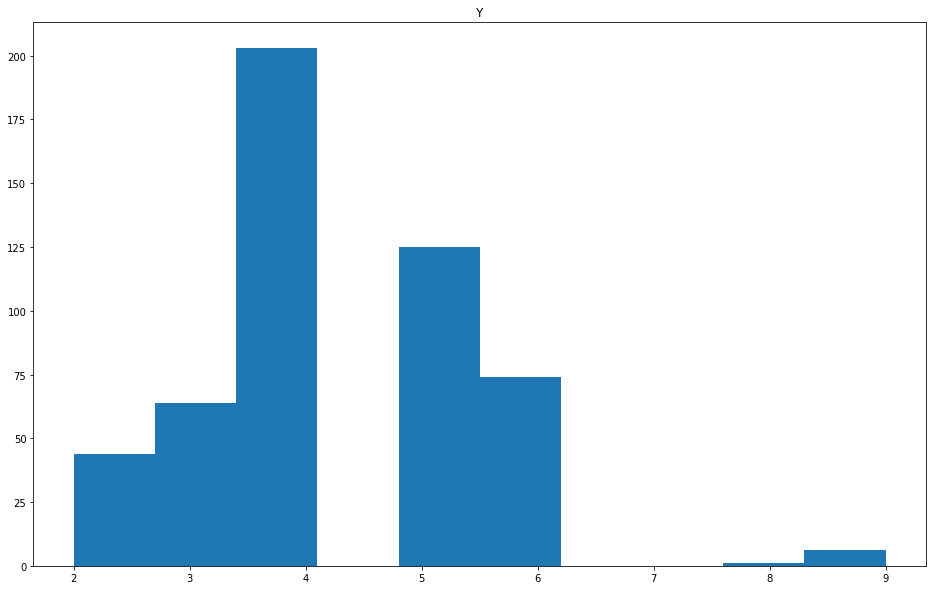

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

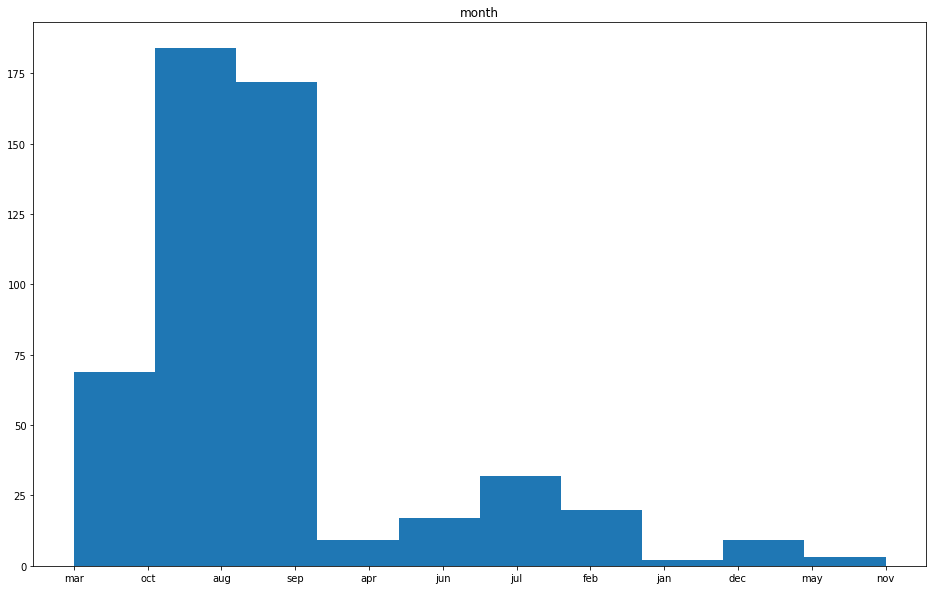

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

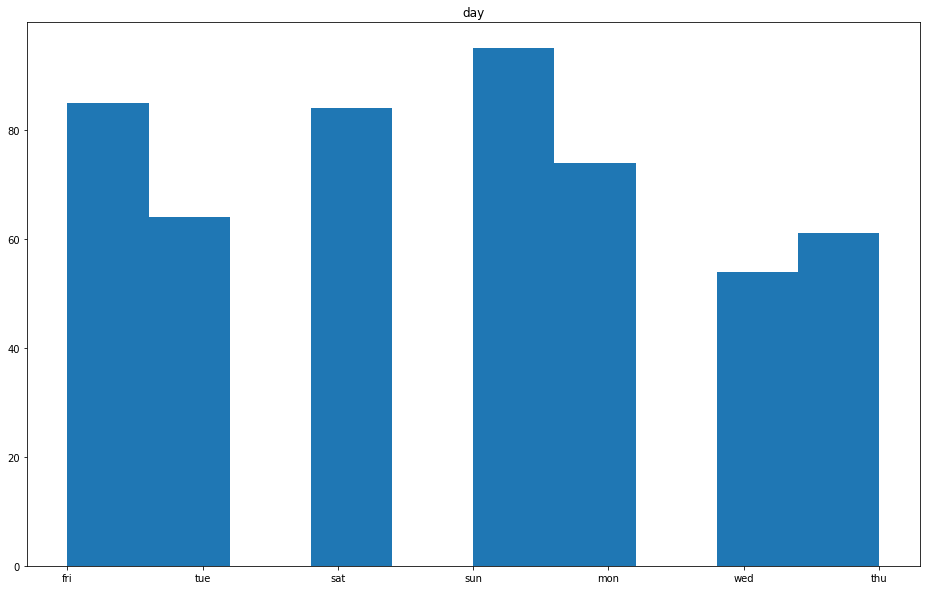

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

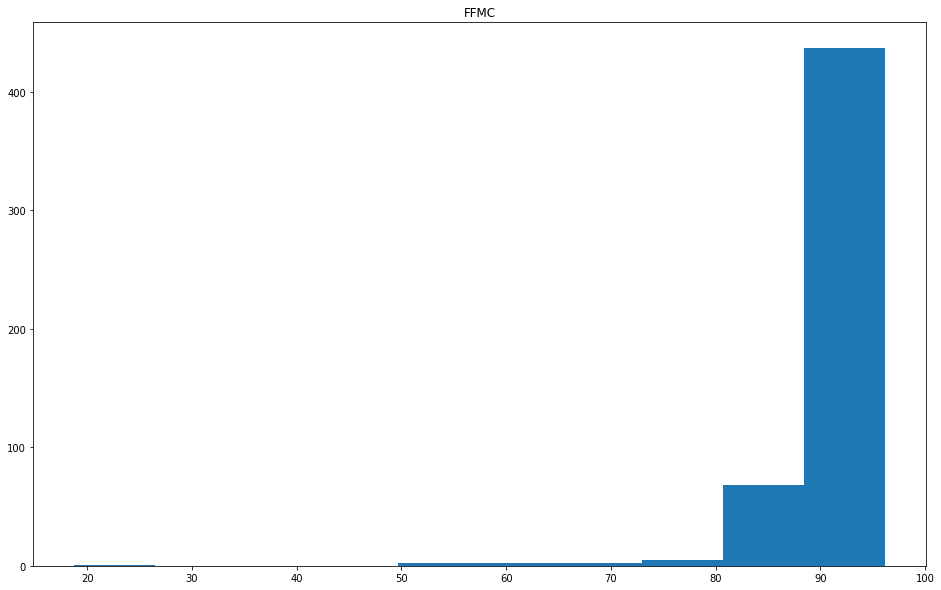

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

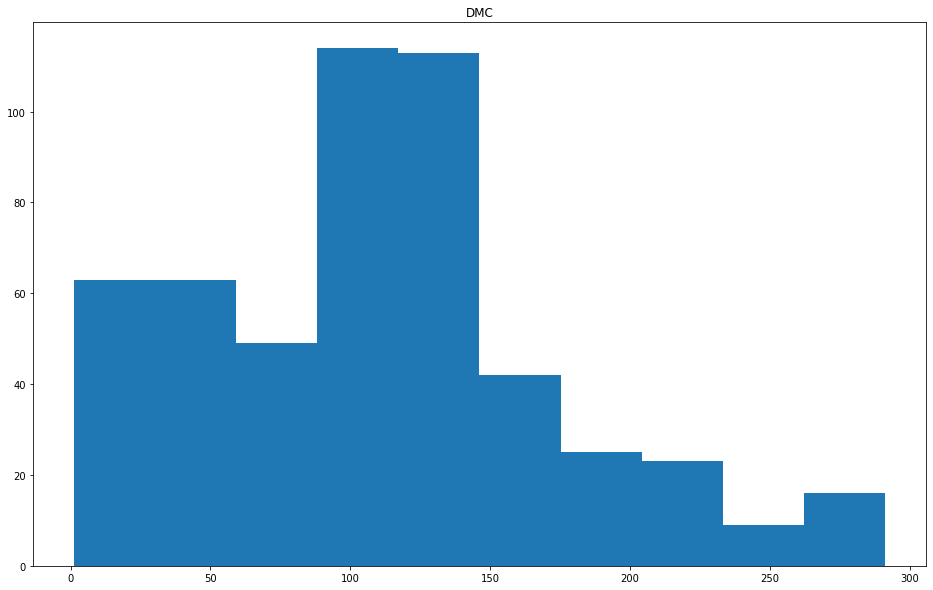

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

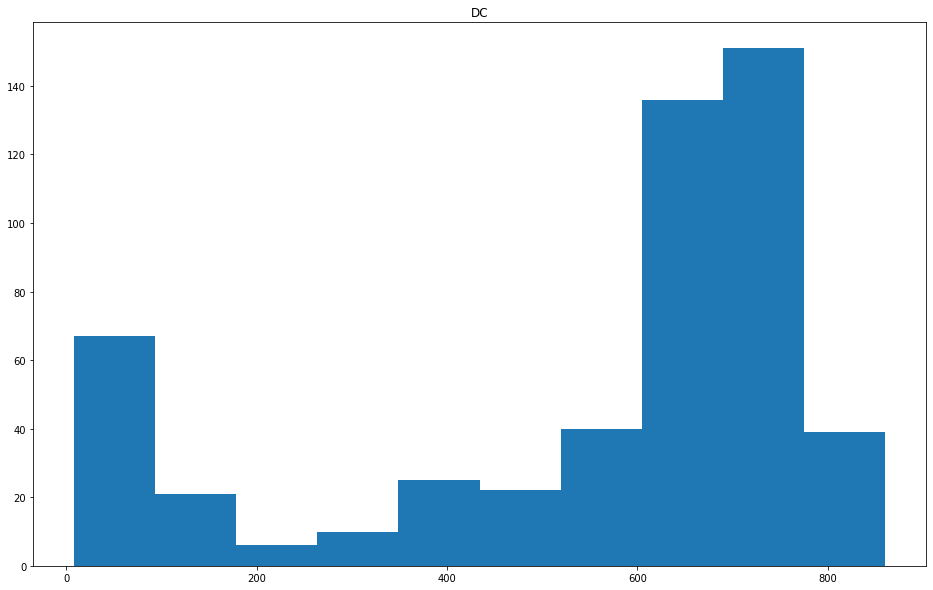

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

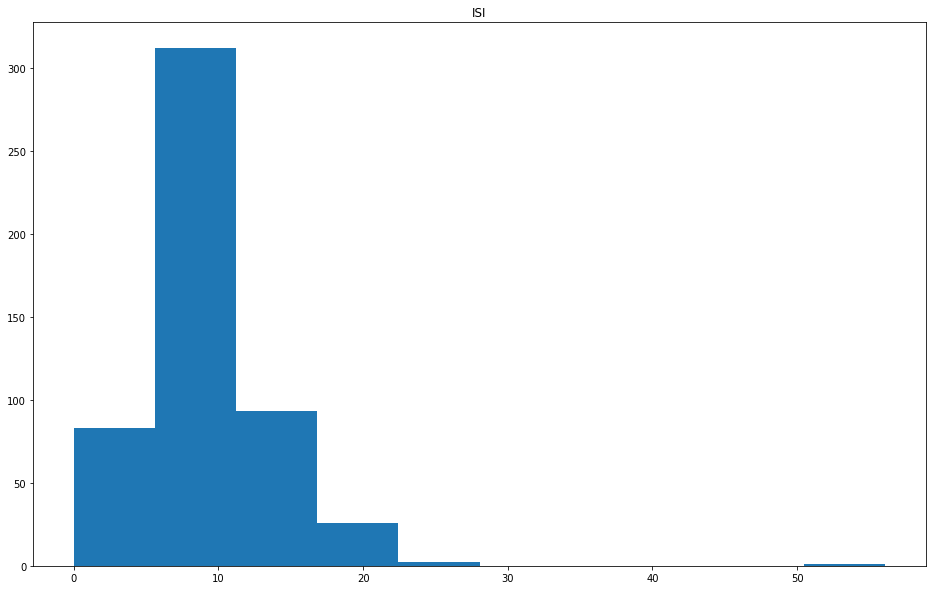

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

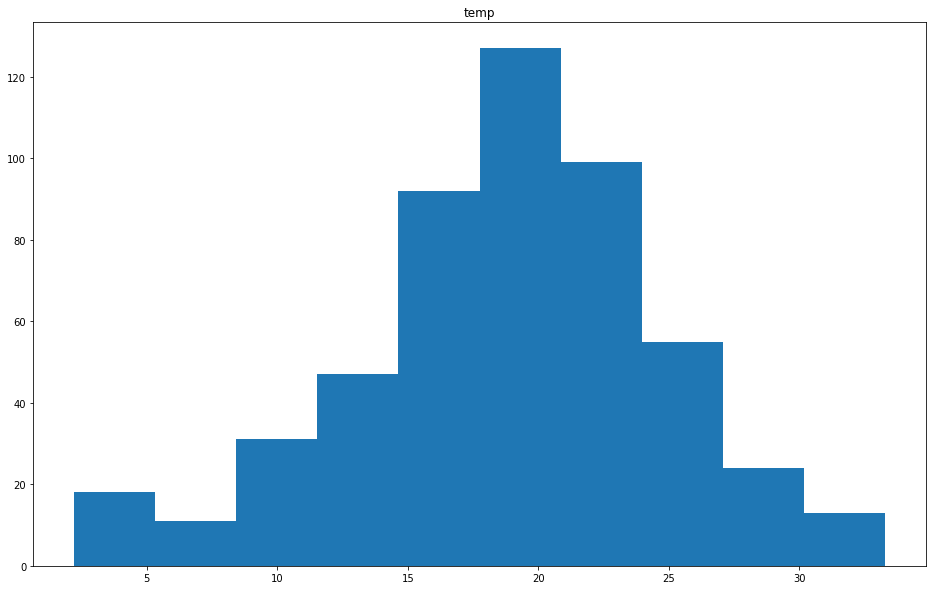

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

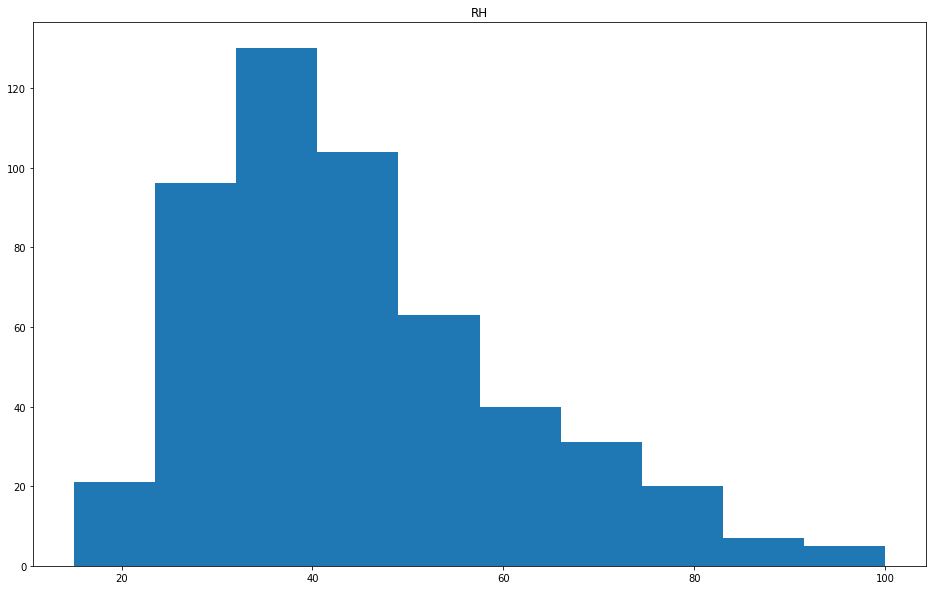

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

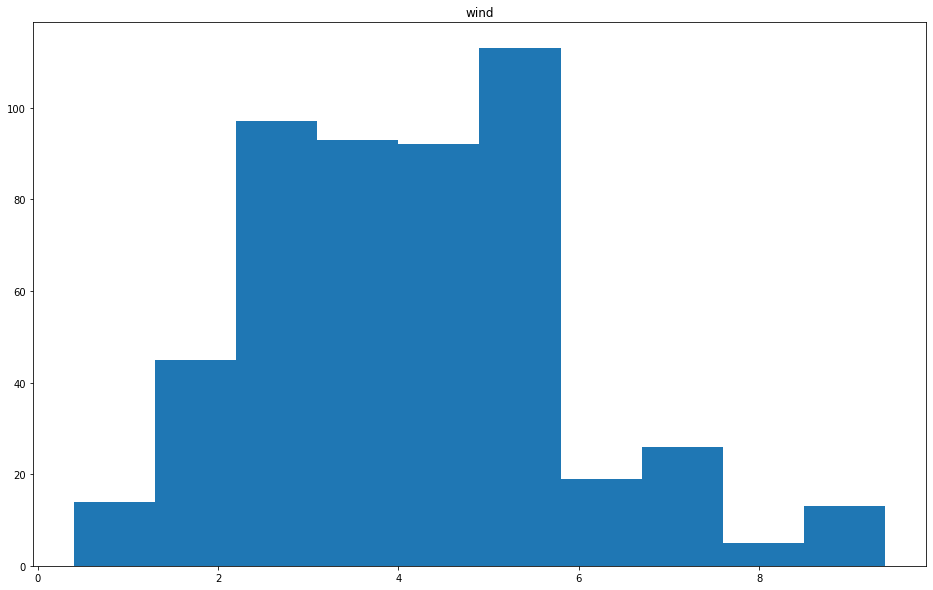

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

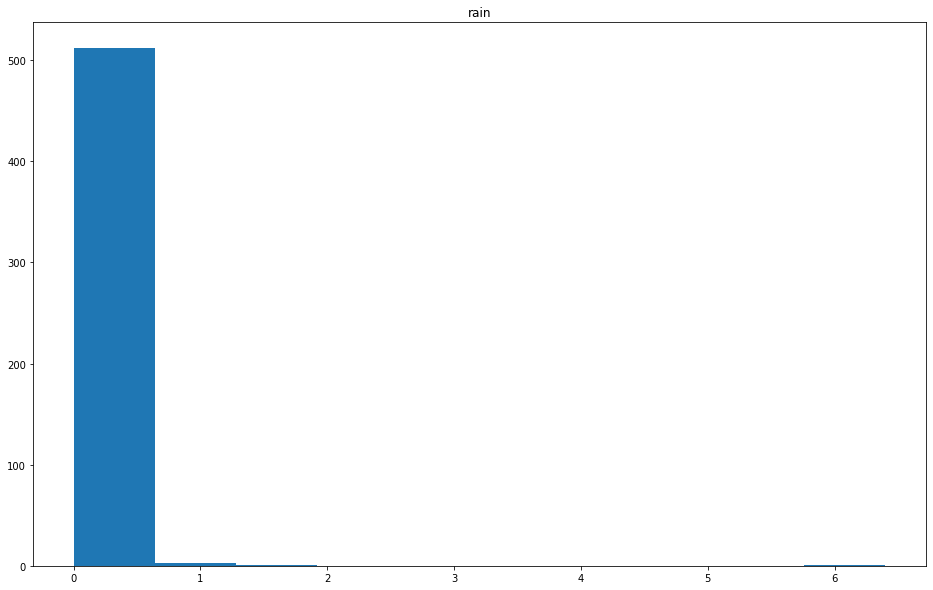

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

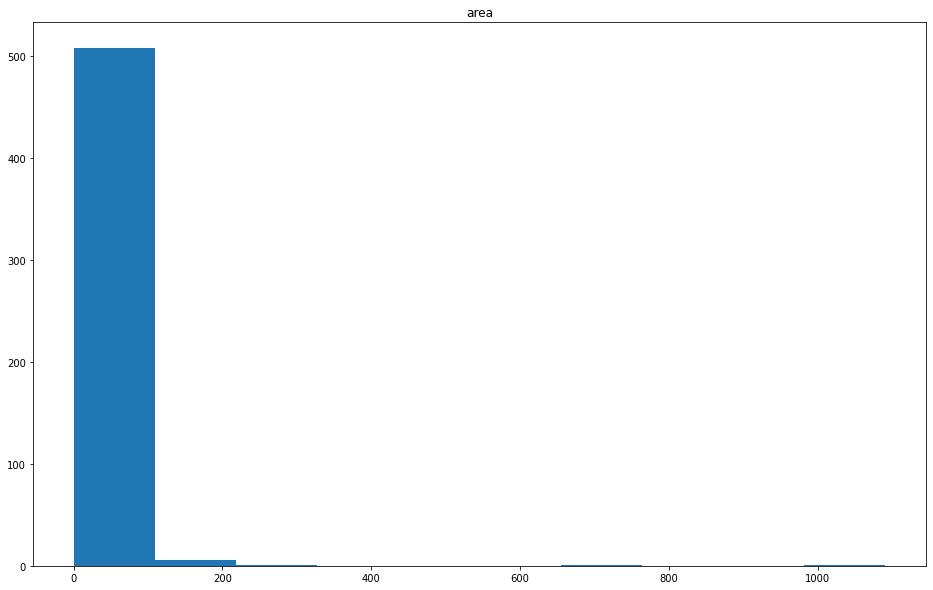

<IPython.core.display.Javascript object>

In [ ]:
wrapp.get_hist_in_tabs(wrapp.dataset, wrapp.all_vars)

- Замечаем, что некоторые распределения выглядят как нормальное (пусть и с небольшими выбросами).

- Однако есть и исключение - напимер, координаты Х и У. Это можно объяснить хотя бы тем, что ландшафт парка нам неизвестен, а следовательно и расположения деревьев, и очаги распространения пожаров. Следовательно распределение не может быть нормальным.

- Интерес представляет гистрограмма "month" и "day", на которых можно отметить следующее:
 1. Наибольшая выгоревшая плоащь от пожаров приходится на теплое время года. 
 2. Расапределение кажется довольно равномерным среди недели, однако в выходные и предвыходные дни количество сожженной площади выше. Это можно объяснить как временем отклика пожарной службы, так и простой человеческой жизнедеятельностью по выходным.

- Можем упростить дальнейшую работу с признаками, закодировав стркоовые значения, заменив их на булевые "summertime", "weekend" соответственно для месяца, дня недели.


### Определяем функции - проверки на летнее и выходное время для последующего кодирования

In [ ]:
def is_summertime(expr) -> int:
  return ((expr == "jun") | (expr == "jul") | (expr == "aug")) #| (expr == "sep"))

def is_weekend(expr) -> int:
  return ((expr == 'sat') | (expr == 'sun'))

- Кодируем информацию в датасете либо True, либо False.

In [ ]:
transform_ds = pd.DataFrame(wrapp.dataset)
# 
transform_ds['month'] = is_summertime(transform_ds['month'])
transform_ds = transform_ds.rename(columns = {"month" : "summertime"})
#
transform_ds['day'] = is_weekend(transform_ds['day'])
transform_ds = transform_ds.rename(columns = {"day" : "weekend"})
#
wrapp.dataset = transform_ds
wrapp.feature_vars = ['X', 'Y', 'summertime', 'weekend', 'FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH', 'wind', 'rain']

- Выводим обновленные красивые гистрограммы для обновленных фичией *summertime*, *weekend*.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


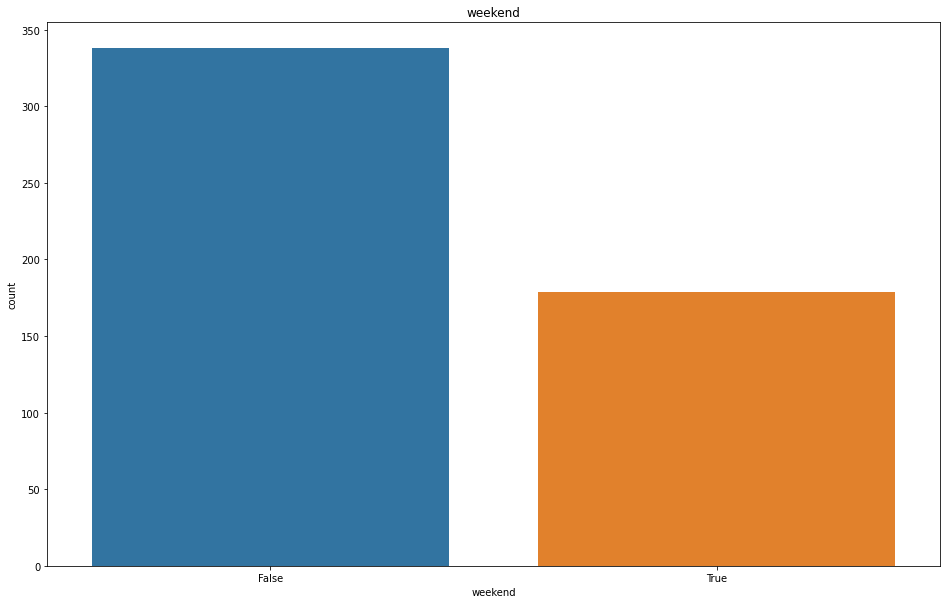

In [ ]:
wrapp.get_pretty_hist("weekend")

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


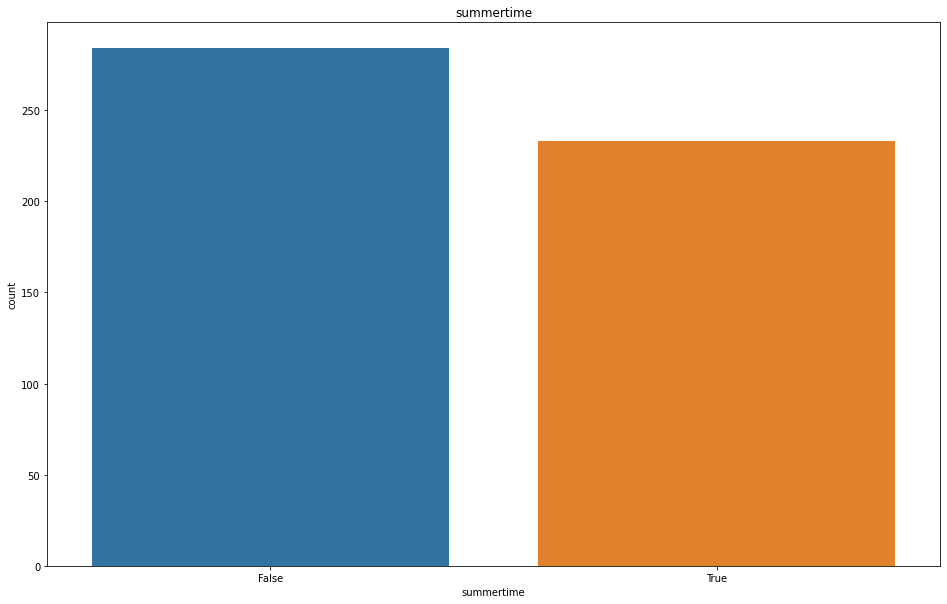

In [ ]:
wrapp.get_pretty_hist("summertime")

- Можно заметить, что распределение для площади и оскадков дождя выглядит не очень хорошо. 
- Выровним данные, масштабировав их с помощью логарифмической функци $ln(1 + x)$ (поскольку распределение в основном располагается вблизи нуля).

In [ ]:
strange_hists = ['rain', 'area']

transform_ds.loc[:, strange_hists] = transform_ds.loc[:, strange_hists].apply(lambda x: np.log(x + 1), axis = 1)
wrapp.dataset = transform_ds

- Видно, что распределению сгоревшей площади стало гораздо лучше, чего не скажешь о данных про дождь.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

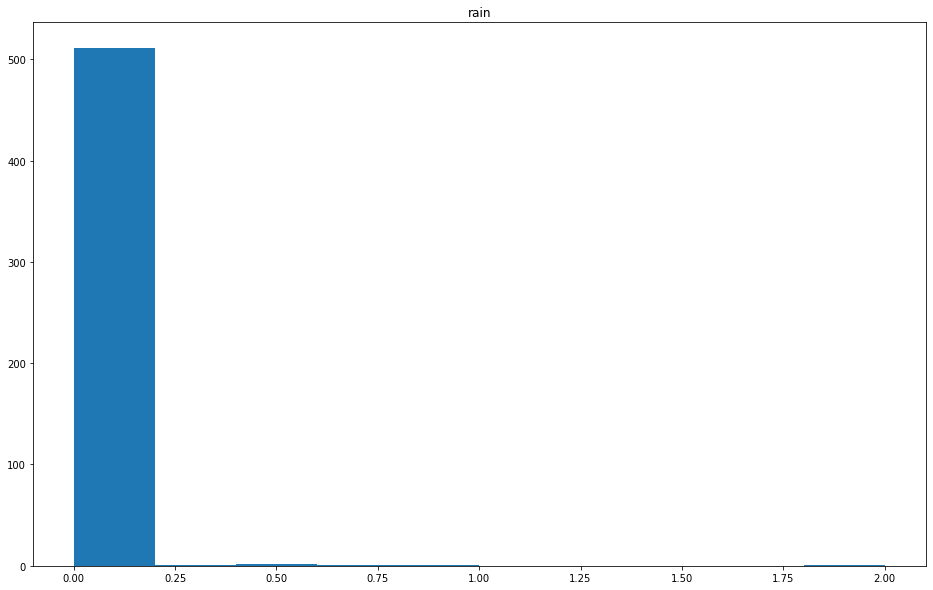

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

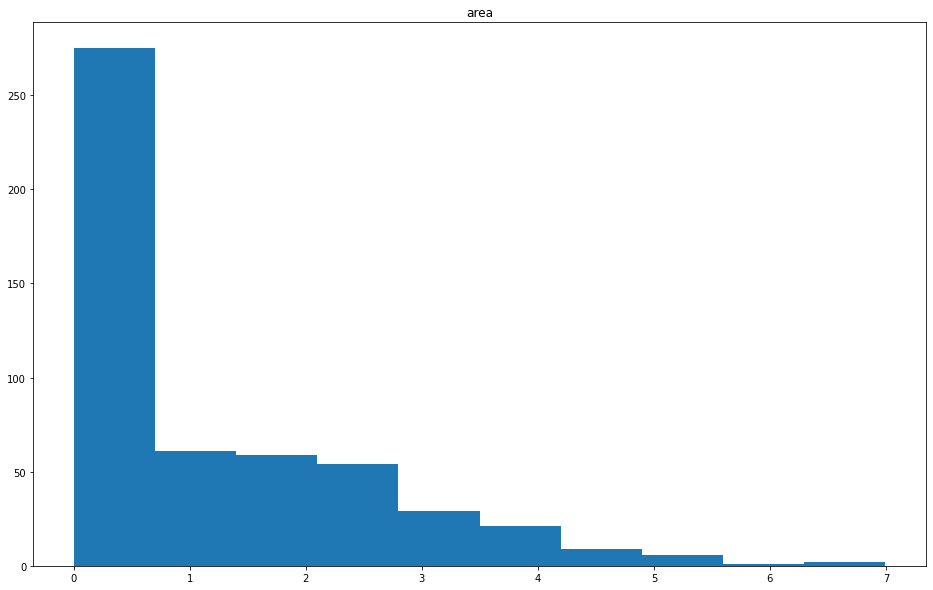

<IPython.core.display.Javascript object>

In [ ]:
wrapp.get_hist_in_tabs(wrapp.dataset, strange_hists)

- Делим исходный датасет на features, target отбрасыванием стобца *area*. 
- После преобразованные данные делим на части train и test примерно так, как показано на картинке.

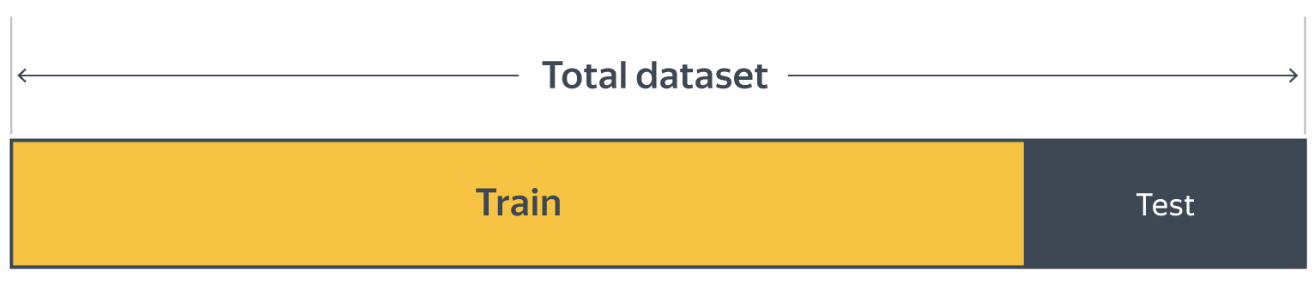

In [ ]:
wrapp.split_dataset(dataset=wrapp.dataset, target_var=wrapp.target_vars, testsize=0.25, random_st = 4)

- Поскольку полученные гистограммы в каком-то приближении даже похожи на нормальные, можем воспользоваться стандартным инструментом машстабирования из библиотеки sklearn.

In [ ]:
wrapp.scale_features()
wrapp.scale_target()

### Анализируем собранный train-датасет.

 Построим:
  1. Гистограмму для всех features.
  2. Кореляционную heatmap'у между featres, target переменными.

In [ ]:
# Need to cast to get corr matrix
wrapp.data2dataframe()

### Для начала проверяем мультиколинеарность наших фич - параметров, рассчитав VIF - variance infaltion factor.

In [ ]:
check_vif(wrapp.features_train)

X             1.445969
Y             1.472440
summertime    1.911395
weekend       1.043834
FFMC          1.639777
DMC           2.809618
DC            2.541097
ISI           1.577584
temp          3.530228
RH            2.206246
wind          1.165540
rain          1.096352
dtype: float64


- Полученные значения < 5 для каждого параметра $\Rightarrow$ умеренная корелляция. Значит, можем работать со всеми фичами, вообще говоря.

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

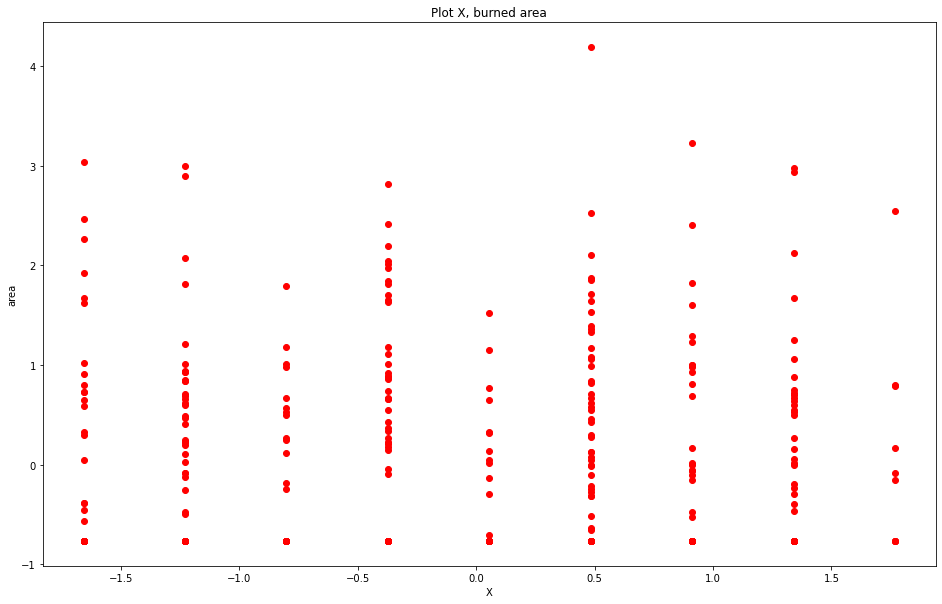

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

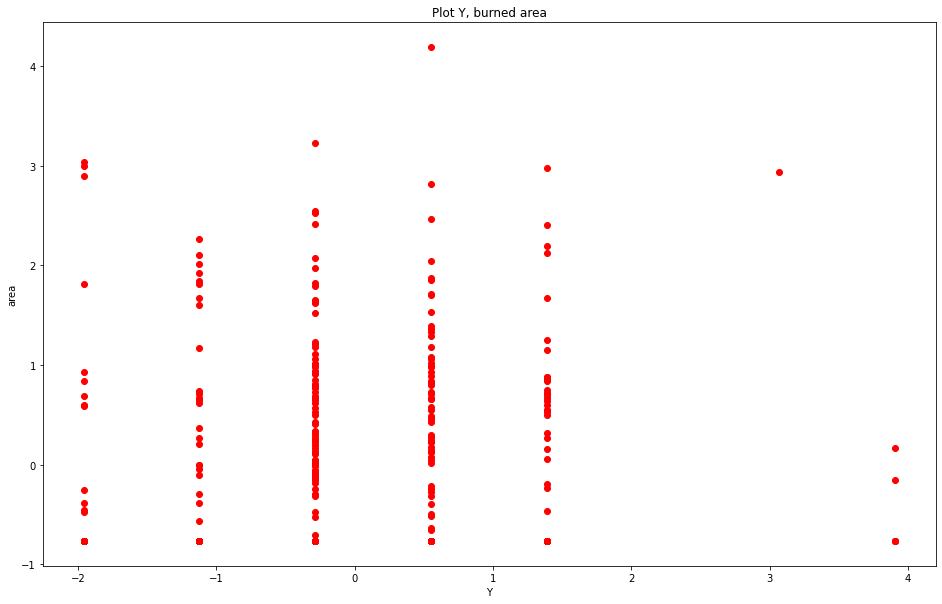

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

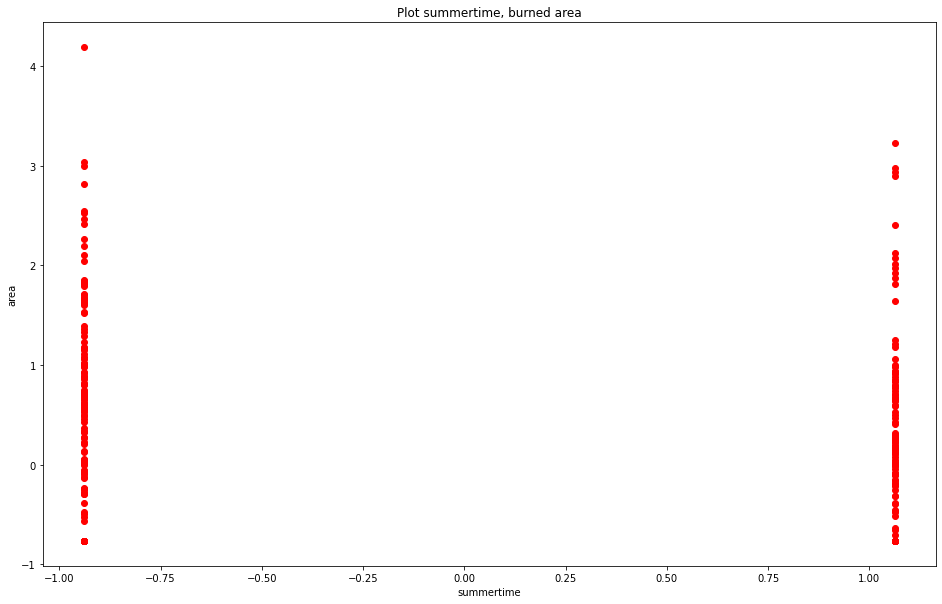

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

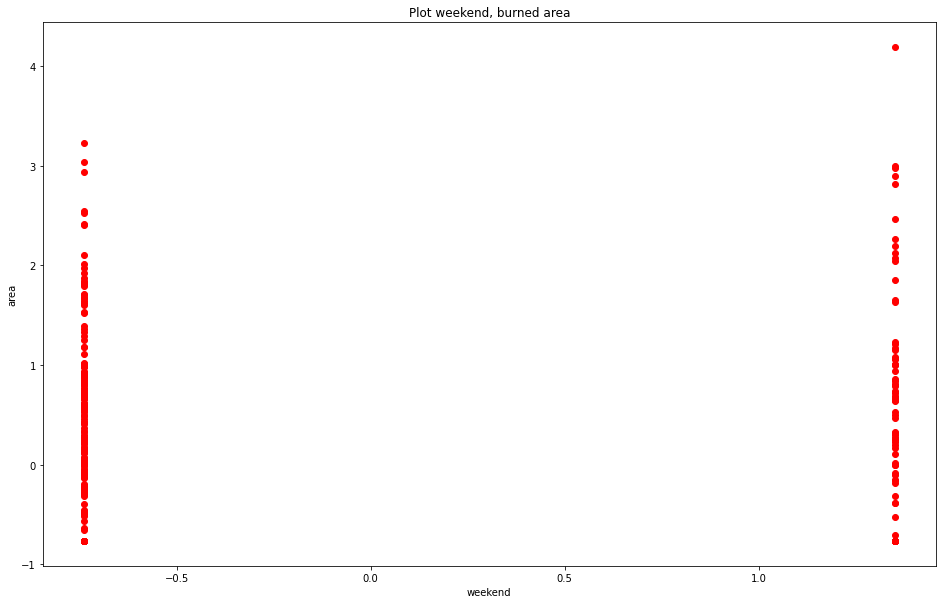

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

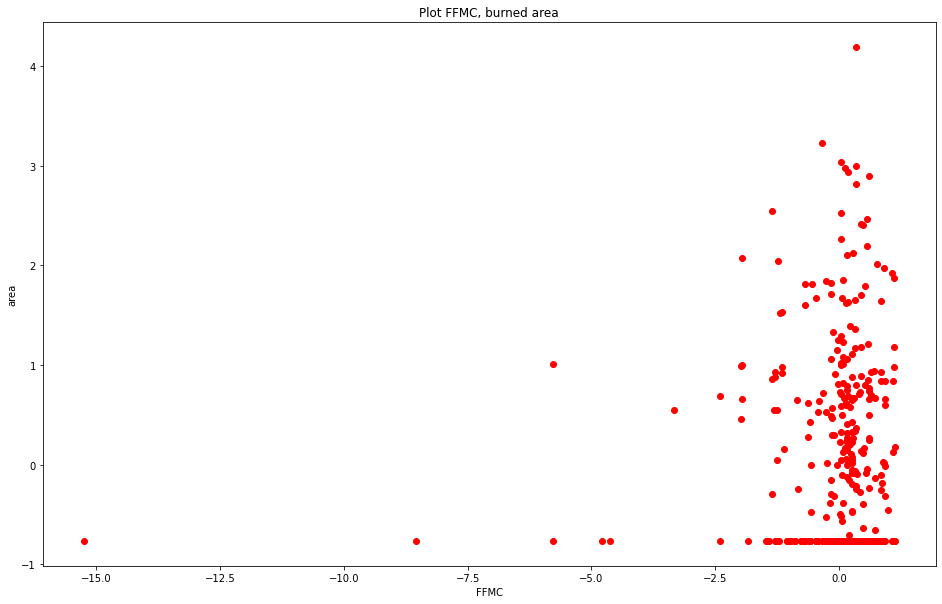

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

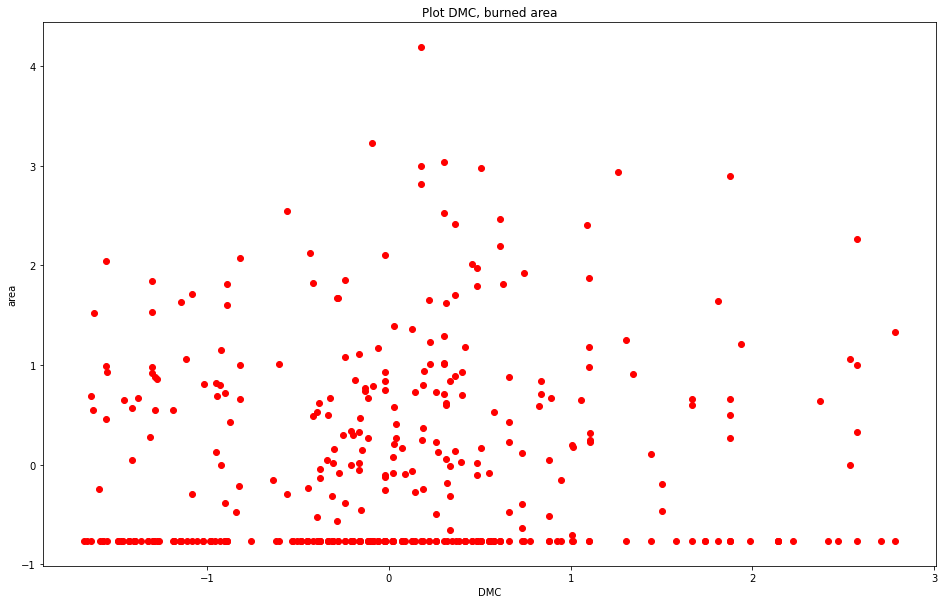

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

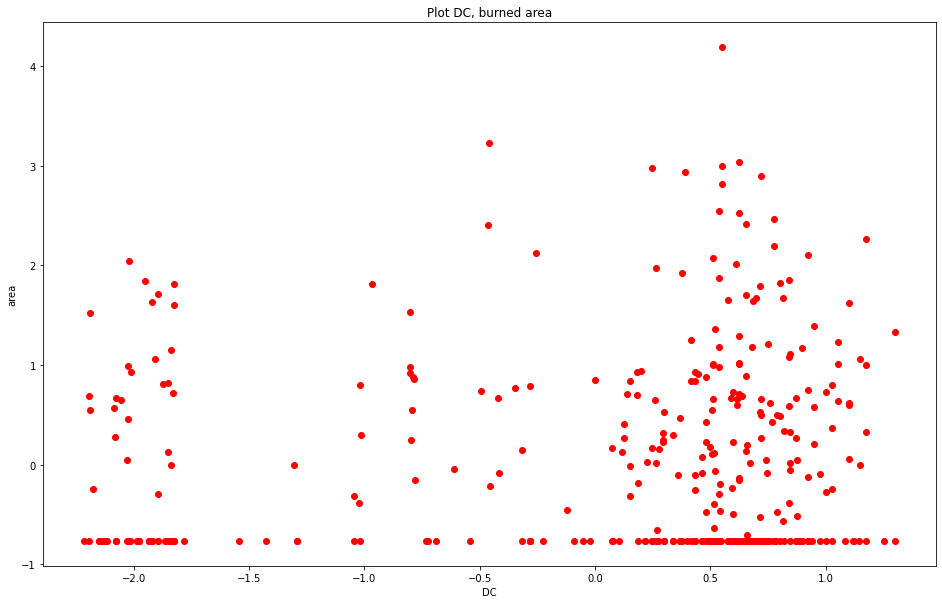

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

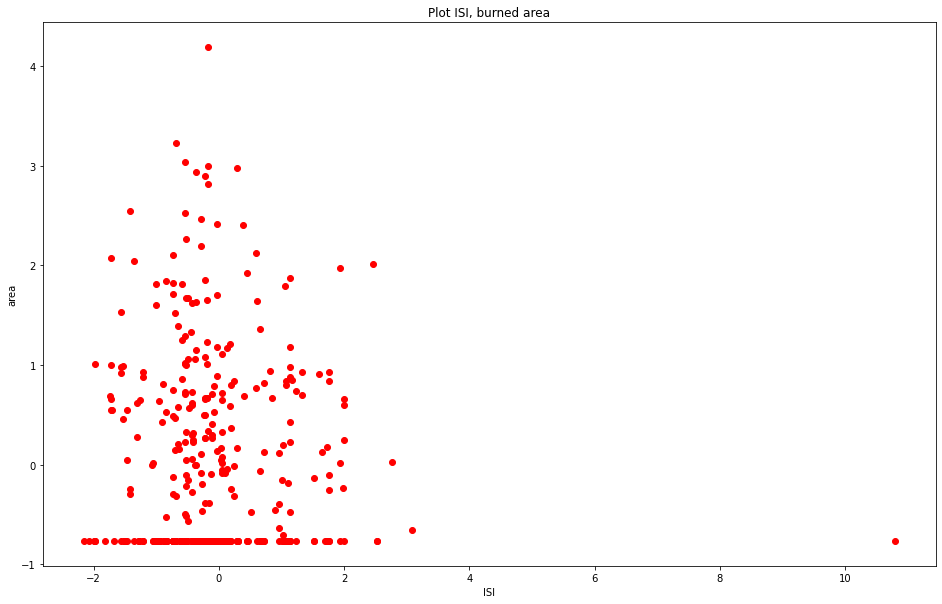

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

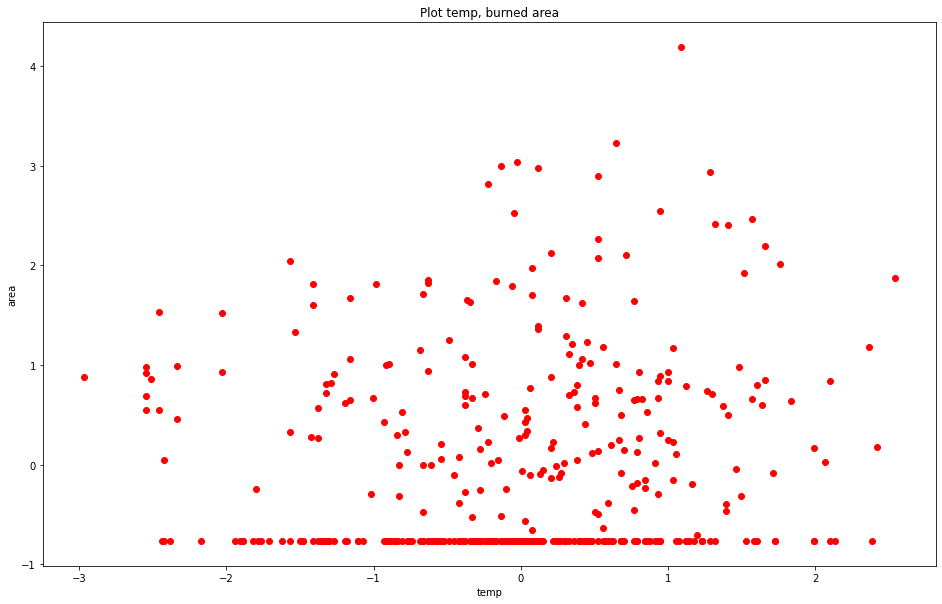

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

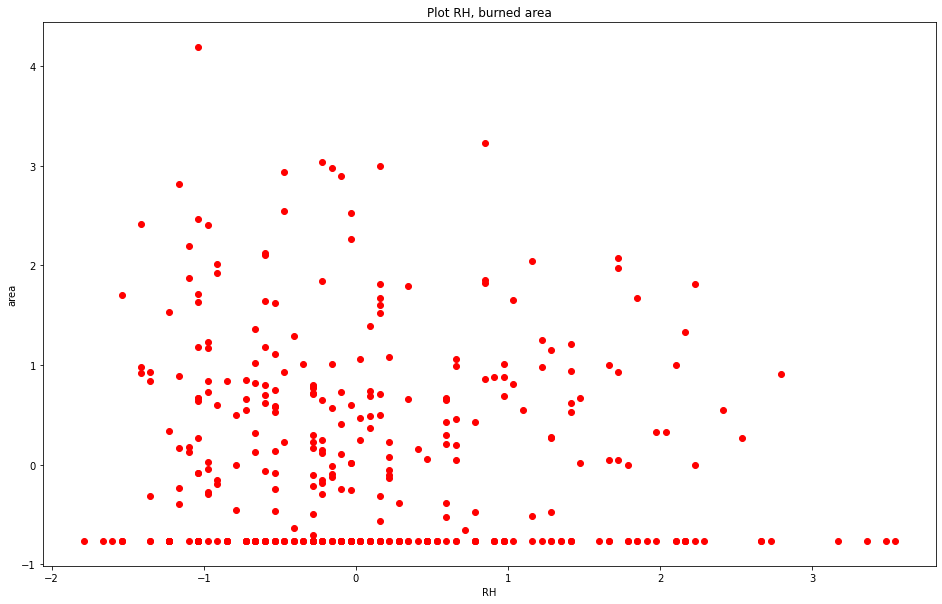

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

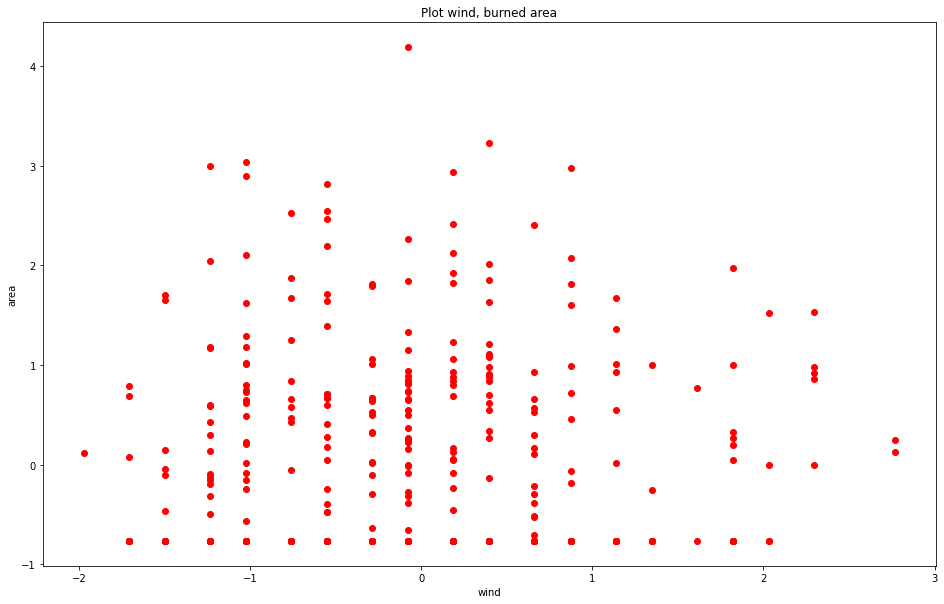

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

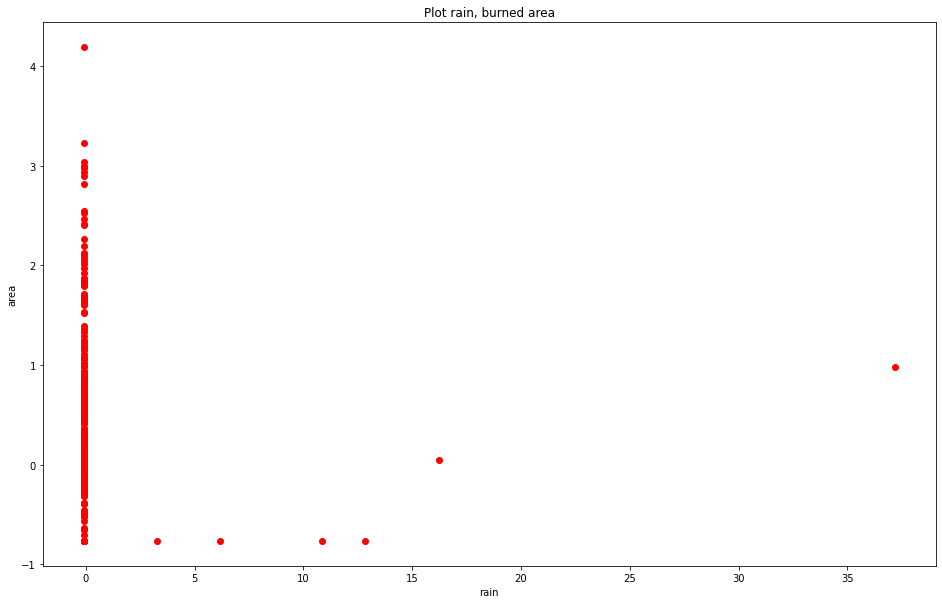

<IPython.core.display.Javascript object>

In [ ]:
wrapp.get_plot_in_tabs(wrapp.features_train, wrapp.target_train, wrapp.feature_vars)

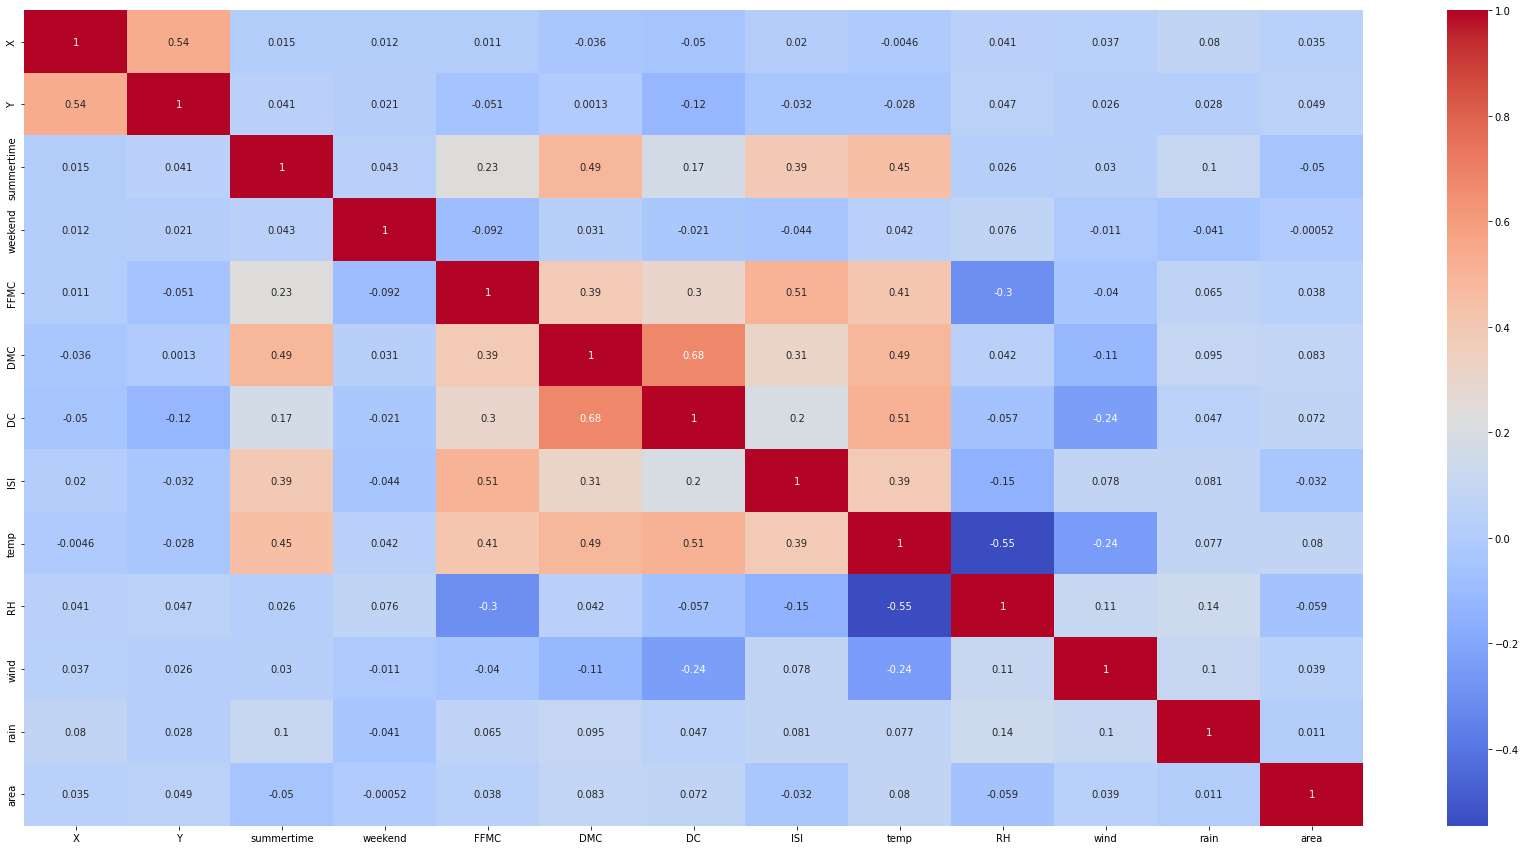

In [ ]:
wrapp.get_corr(join_data(wrapp.features_train, wrapp.target_train))

- По heatmap'e замечаем, что сгоревшая площадь особо не кореллирует сильно с другими величинами
- По графикам фича - таргет видим, что некоторые зависимости нельзя описать каким-то линейный законом.


1. Не прудумав нужного решения для масштабирования, например, зависимости скорости ветра от сгоревшей площади, попытаемся отобрать наиболее подходящие фичи из тех, что есть.

2. Чтобы отобрать из полученных метрик наиболее кореллирующие с area, установим порог для корелляции. 
Пусть будет 0.06 $\Rightarrow$ это будет [DMC, RH, temp, DMC].

- Обновляем лист фичей и приводим датасеты к numpy массивам.

In [ ]:
new_features = list(["RH", "DMC", "DC", "temp"])
wrapp.upd_features(new_features)
# Neet to cast to work w/ prediction models: linear regression, FDN, prerceptron
wrapp.data2numpyarr()

## 2. Реализация линейной регрессии:

Вкратце о реализации:
1. Была взята модель из модуля sklearn.
2. После сравниваем предсказанный результат с действительным.

For the train set the r2 is: 0.01097
The RMSE is: 0.98200
For the test set the r2 is: -0.00101
The RMSE is: 1.00050


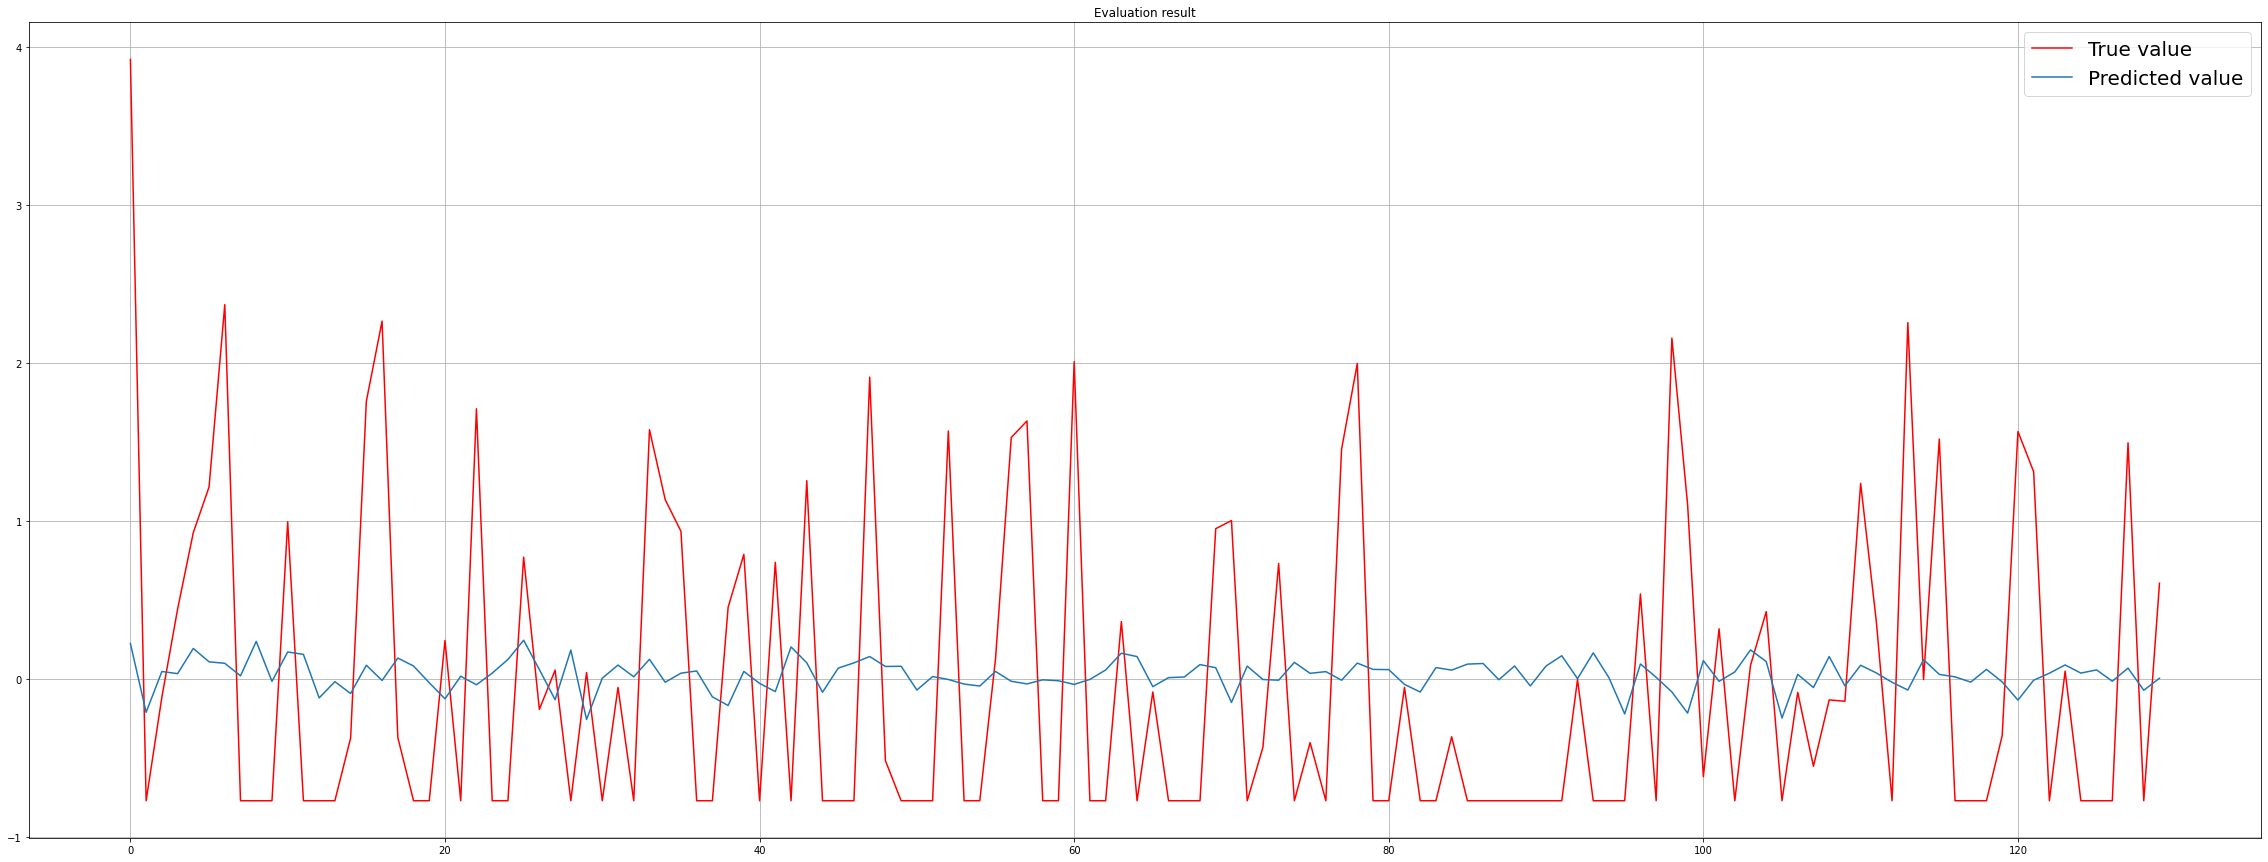

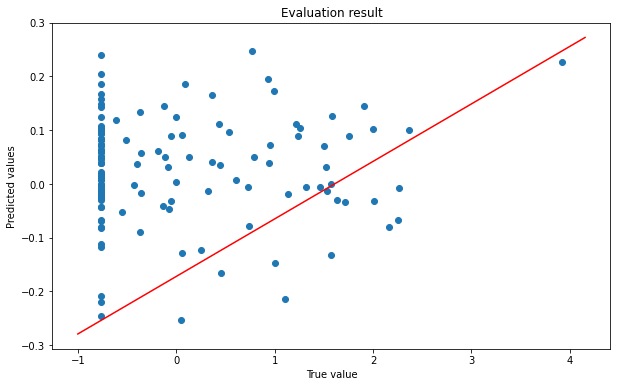

In [ ]:
model = LinearRegression().fit(wrapp.features_train, wrapp.target_train)
target_test_predict, r2 = wrapp.run_model(model, True)
wrapp.plot_compare(target_test_predict)
wrapp.evaluation(target_test_predict)

## 3. Реализация модели, основанной на формуле Надарая Ватсона

In [ ]:
from scipy.spatial.distance import cdist
#implementation of formula
class FNV(object):
    def __init__(self, kernel=None):
        self.X, self.Y = None, None
        self.kernel = lambda x: np.ones_like(x)
        if kernel is not None:
            self.kernel = kernel

    def predict(self, X):
        features = np.sum(self.Y * self.kernel(cdist(X, self.X)), axis=-1)
        return features / (np.sum(self.kernel(cdist(X, self.X)), axis=-1) + 1e-10)
        
    def fit(self, X, Y):
        self.X, self.Y = np.array(X), np.array(Y)

In [ ]:
# NOTE: kernel implementation
def K(distance, h=0.2):
    ret = np.array(distance) / h
    return (1 - ret**2) * (np.abs(ret) <= 1)

# NOTE: function to get w-param for better r2 score to test dataset
# NOTE: w - width param
def get_optimal_h():
  max = 0
  h_opt = 2

  for h_i in range(0, 200):
    h = h_i * 0.1 + 0.1
    model = FNV(kernel=lambda x: K(x, h=h))
    model.fit(wrapp.features_train, wrapp.target_train) 
    fnv_target_test_predict, r2 = wrapp.run_model(model)
    #
    if (max < r2):
      max = r2  
      h_opt = h


  return h_opt, max

In [ ]:
h_opt, max = get_optimal_h()
print(f'Optimal h = {h_opt:.1f}, r2_score = {max:.5f}')

Optimal h = 2.0, r2_score = 0.01539


In [ ]:
model_fnv = FNV(kernel=lambda x: K(x, h=h_opt))
model_fnv.fit(wrapp.features_train, wrapp.target_train)

For the train set the r2 is: 0.04538
The RMSE is: 0.96476
For the test set the r2 is: 0.01539
The RMSE is: 0.99227


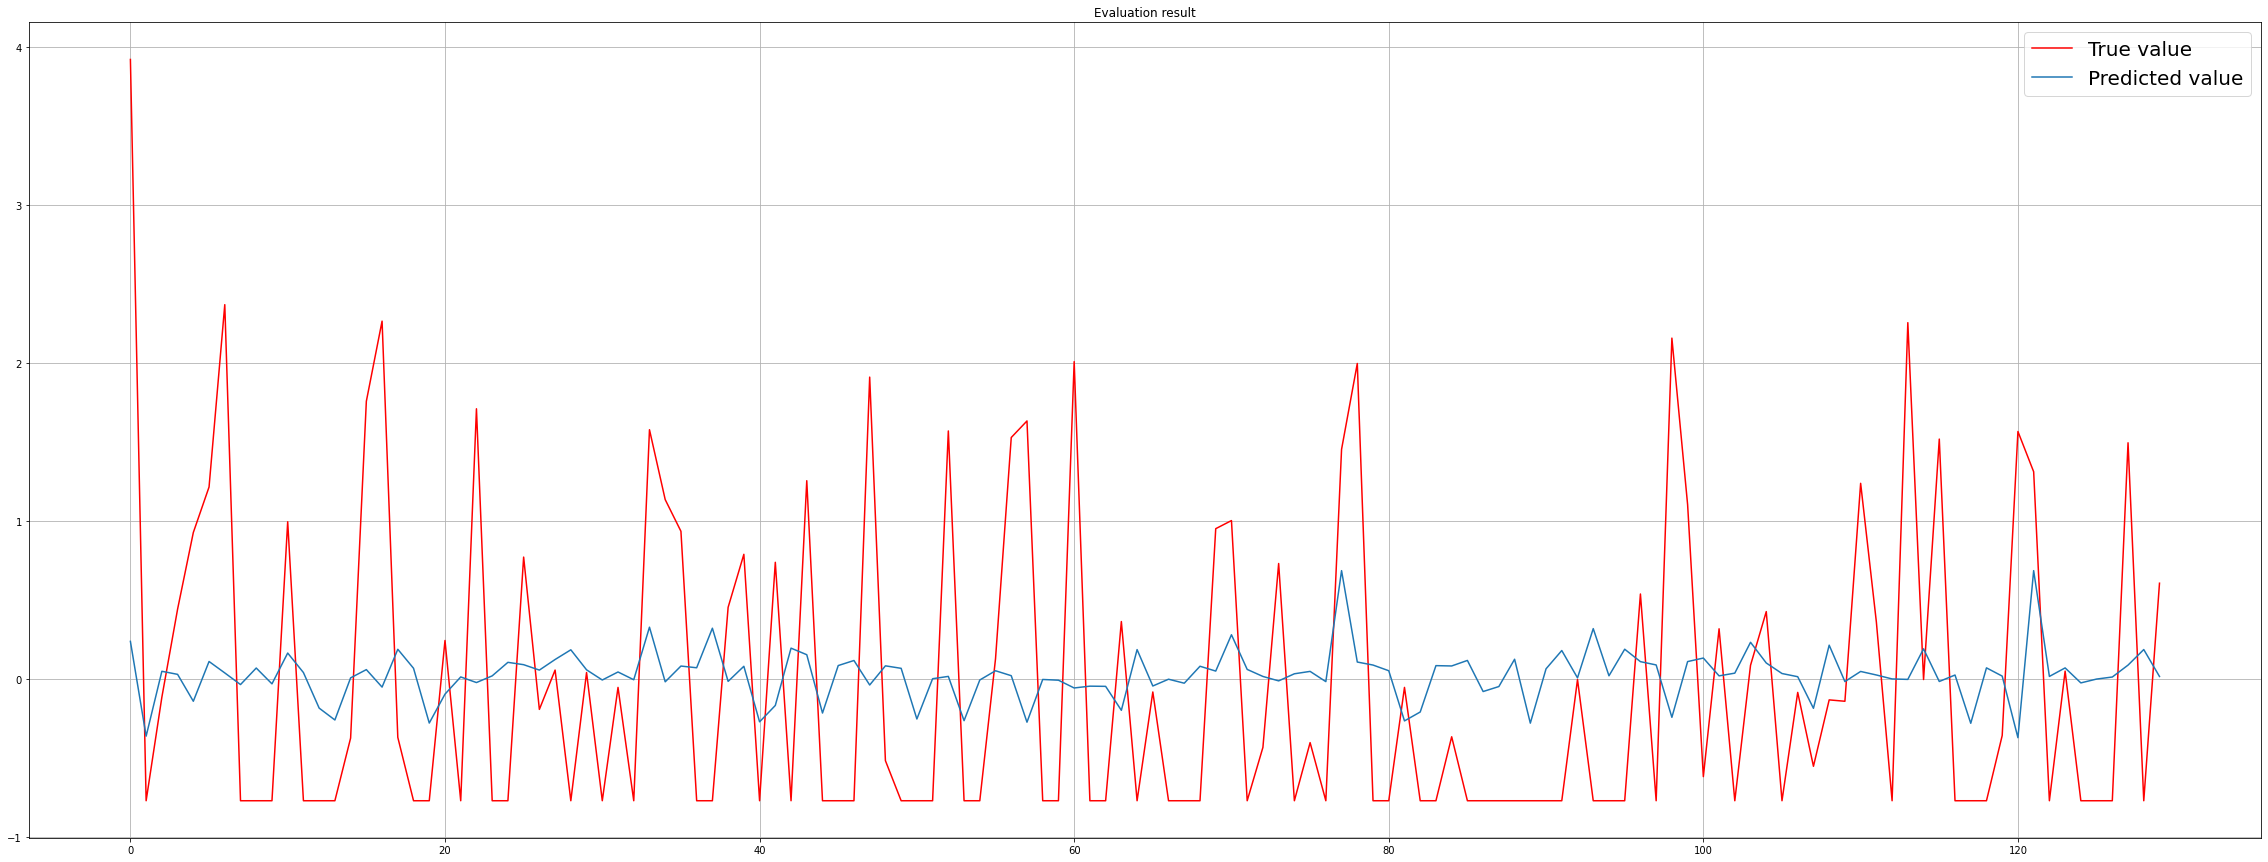

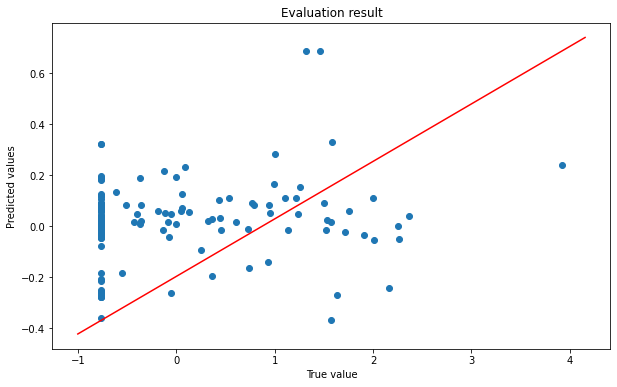

In [ ]:
fnv_target_test_predict, r2 = wrapp.run_model(model_fnv, True)
wrapp.plot_compare(fnv_target_test_predict)
wrapp.evaluation(fnv_target_test_predict)

## 4. Реализация модели перцептрона

In [ ]:
from sklearn.neural_network import MLPRegressor

In [ ]:
class PercWrapp:
  def __init__(self):
    self.state = 9
    self.alpha = 0.1
    self.layers_num = 65
    self.neur_num = 1
    self.valid_fract = 0.025

    self.iter_num = 10000
    
    self.model = MLPRegressor(random_state=self.state, max_iter = self.iter_num,\
                              hidden_layer_sizes = tuple([self.neur_num for _ in range(0, self.layers_num)]),\
                              alpha=self.alpha, validation_fraction=self.valid_fract, early_stopping = True)
    #
  # NOTE : optimal neuron params getter
  def get_opt_neuron_params(self):
    max = 0
    cur_layers, cur_neur = self.layers_num, self.neur_num

    for layr_it in range(3, 10):
      for neur_it in range(10, 200):
        perc = MLPRegressor(random_state=self.state, max_iter = self.iter_num,\
                            hidden_layer_sizes = tuple([neur_it for _ in range(0, layr_it)]),\
                            alpha=self.alpha, validation_fraction=self.valid_fract, early_stopping = True)
        #
        perc.fit(wrapp.features_train, wrapp.target_train)
        prcp_target_test_predct, r2 = wrapp.run_model(perc)

        if (max < r2):
          max = r2
          cur_layers, cur_neur = layr_it, neur_it
          
    self.neur_num = cur_neur
    self.layers_num = cur_layers 

    return self.neur_num, self.layers_num

  # NOTE : optimal alpha getter
  def get_opt_alpha(self):
    max = 0
    cur_alpha_opt = self.alpha
    #
    for alpha_it in range(1, 110):
      cur_alpha = alpha_it * 0.01
      perc = MLPRegressor(random_state=self.state, max_iter = self.iter_num,\
                          hidden_layer_sizes = tuple([self.neur_num for _ in range(0, self.layers_num)]),\
                          alpha=cur_alpha, validation_fraction=self.valid_fract, early_stopping = True)
      #
      perc.fit(wrapp.features_train, wrapp.target_train)
      prcp_target_test_predct, r2 = wrapp.run_model(perc)
      #
      if (max < r2):
        max = r2
        cur_alpha_opt = cur_alpha

    self.alpha = cur_alpha_opt
    return self.alpha, max
    #
  #
  # NOTE : optimal validation fraction getter
  def get_opt_valid_fract(self):
    cur_valid_fract_opt = 0
    max = 0
    for valid_fract_it in range(300, 500, 5):
      cur_valid_fract = valid_fract_it * 0.0001
      perc = MLPRegressor(random_state=self.state, max_iter = self.iter_num,\
                          hidden_layer_sizes = tuple([self.neur_num for _ in range(0, self.layers_num)]),\
                          alpha=self.alpha, validation_fraction=cur_valid_fract, early_stopping = True)
      #
      perc.fit(wrapp.features_train, wrapp.target_train)
      prcp_target_test_predct, r2 = wrapp.run_model(perc)

      if (max < r2):
        max = r2
        cur_valid_fract_opt = cur_valid_fract
    
    self.valid_fract = cur_valid_fract_opt 
    return self.valid_fract, max 
    #
  #

  # NOTE : optimal validation fraction getter
  def fit(self, features_train, target_train):
    self.model.fit(features_train, target_train)

  #
  def update_model(self):
    self.model = MLPRegressor(random_state=self.state, max_iter = self.iter_num,\
                        hidden_layer_sizes = tuple([self.neur_num for _ in range(0, self.layers_num)]),\
                        alpha=self.alpha, validation_fraction=self.valid_fract, early_stopping = True)


### Определим функции подбора гиперпараметров



In [ ]:
perc = PercWrapp()

In [ ]:
cur_layers, cur_neur = perc.get_opt_neuron_params()
print(f'Optimal count of layers = {cur_layers}, optimal count of neurons = {cur_neur}, r2_score = {max:.5f}')

Optimal count of layers = 21, optimal count of neurons = 5, r2_score = 0.01539


In [ ]:
cur_alpha_opt, max = perc.get_opt_alpha()
print(f'Optimal alpha = {cur_alpha_opt:.2f}, r2_score = {max:.5f}')

Optimal alpha = 0.06, r2_score = 0.03097


In [ ]:
optim_valid_fact, max = perc.get_opt_valid_fract()
print(f'Optimal validation factor = {cur_alpha_opt:.2f}, r2_score = {max:.5f}')

Optimal validation factor = 0.06, r2_score = 0.03024


In [ ]:
perc.update_model()
perc.fit(wrapp.features_train, wrapp.target_train)
prcp_target_test_predct, r2 = wrapp.run_model(perc.model, True)

For the train set the r2 is: 0.03557
The RMSE is: 0.96971
For the test set the r2 is: 0.03024
The RMSE is: 0.98476


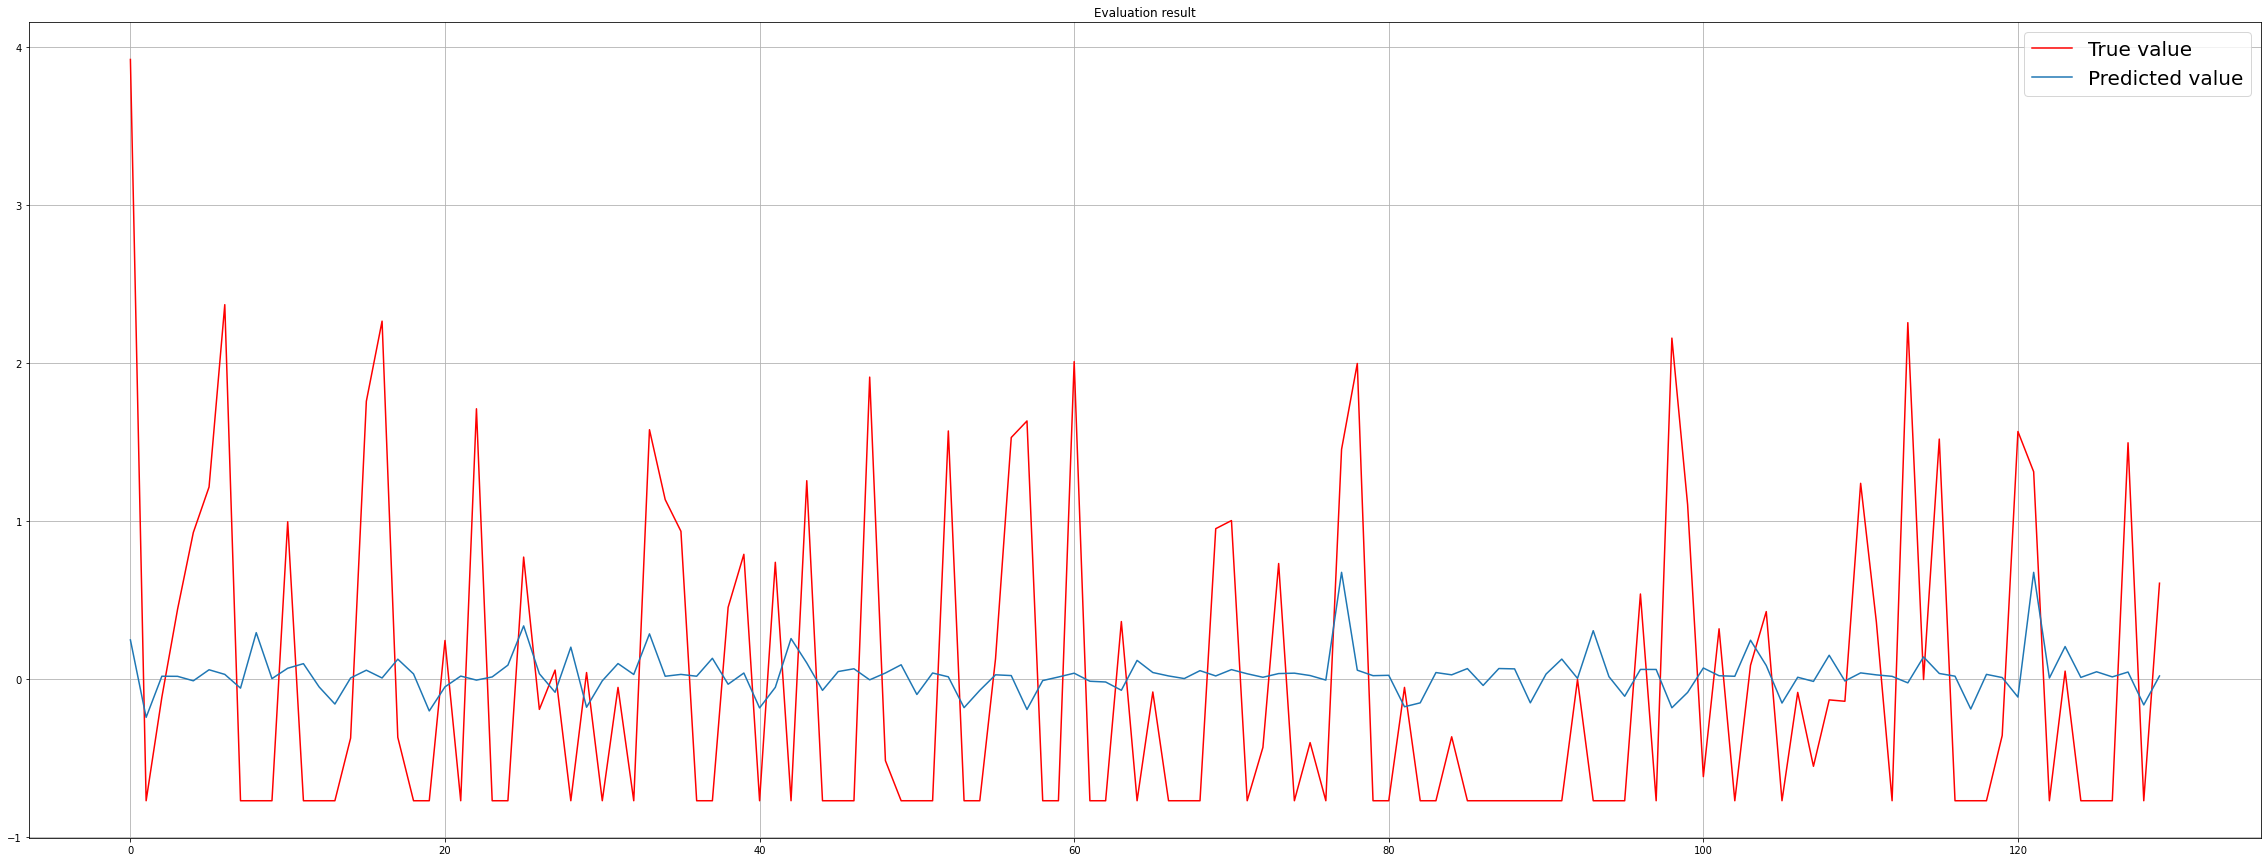

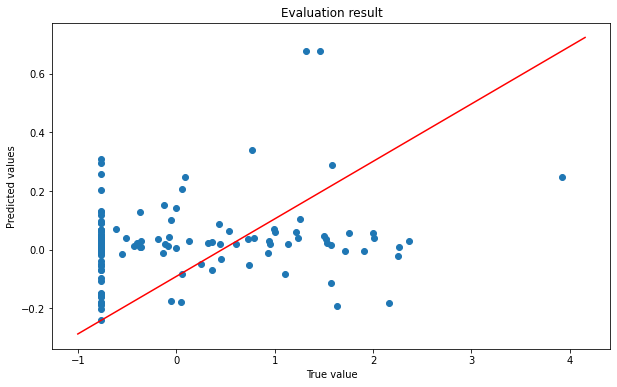

In [ ]:
wrapp.plot_compare(prcp_target_test_predct)
wrapp.evaluation(prcp_target_test_predct)

## Вывод
____________________________________________________________________

1. **Линейная регрессия.**

- Мало того, что при обучении коэффициент детерменации (он же $r2$ в моей реализации) был запредельно низким, после прогона на train выборке все стало еще хуже: показатель стал отрицательным. А это означает, что **все очень плохо**. Получается, что модель, построенная на линейной регрессии, обрабатывающая кропотливо обработанный датасет даже хуже горизонтальной линии-предсказателя.

2. **Модель, построенная на формуле Надарая - Ватсона.**

- Тут заметен прогресс. Итеративно подбирался гиперпараметр $h$ - ширина окна. 
Коэффициент детерменации получился $r2 \approx 0.01539$. Однако пользы от такого предсказания тоже несильно много.

3. **Перцептрон.**

- Как и ожидалось, перцептрон показал наилучший результат, если так, конечно можно скзаать о полученном результате: $r2 \approx 0.03024$. Итеративно подбирались гиперпараметры: число слоев, число перцептронов, параметр кросс-валидации, а так же параметр регуляризации. 

*Я выделил несколько причин столь ужасных результатов:*
1. Проблемный датасет: непонятки с тем, как именно стоит кодировать летние месяцы (учитывать ли сентябрь, допустим), отсутсвие высокой корелляции параметра area с другими переменными и так далее. 

2. Мой личный недостаток опыта работы в области машинного обучения.